# Проект по А/B-тестированию

**Постановка задачи**

<p>Провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.</p>
<p>Оцените корректность проведения теста.</p>
<p>Проанализируйте результаты теста.</p>


# 1. Загрузка данных

In [1]:
!pip install -U kaleido

import kaleido

import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2



Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 65.9/65.9 MB 2.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

Загружаем датасеты

In [3]:
marketing_evnt = pd.read_csv(r'D:\for_github\project_final\ab_test\ab_project_marketing_events.csv')
users = pd.read_csv(r'D:\for_github\project_final\ab_test\final_ab_new_users.csv')
evnts = pd.read_csv(r'D:\for_github\project_final\ab_test\final_ab_events.csv')
test = pd.read_csv(r'D:\for_github\project_final\ab_test\final_ab_participants.csv')

In [4]:
def print_head(df):
    return df.head()

In [5]:
for i in [marketing_evnt, users, evnts, test]:
    display(print_head(i))


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


# 2. Предобработка данных

In [6]:
def df_info(df):
    return df.info()

for i in [marketing_evnt, users, evnts, test]:
    print(df_info(i))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 n

Все столбцы названы корректно

**2.1 Проверим таблицы на дубликаты**

In [7]:
marketing_evnt.duplicated().sum()

0

In [8]:
users.duplicated().sum()

0

In [9]:
evnts.duplicated().sum()

0

In [10]:
test.duplicated().sum()

0

В датасетах не обнаружены дубликаты

**2.2 Посмотрим на пропуски в таблицах**

In [11]:
marketing_evnt.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [12]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [13]:
evnts.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [14]:
pd.DataFrame(round(evnts.isna().mean()*100)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,86.000000


In [15]:
evnts[evnts['details'].isna()]

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


В датасете с событиями новых пользователей присутствуют пропуски (86%) в столбце details. Но они обусловлены тем, что в этой колонке указывается сумма покупки, а там, где покупка не предполагается - пропуски.

In [16]:
test.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

**2.3 Для дальнейшего анализа оюъединим датасеты: users, events и test.**

In [17]:
united_df = test.merge(evnts, on = 'user_id', how='left').merge(users, on='user_id', how='left')

# 3. Проверка ТЗ

In [18]:
united_df

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-23 13:03:17,login,NaN,2020-12-20,EU,Android
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14 19:12:49,login,NaN,2020-12-14,EU,PC
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-15 01:50:22,login,NaN,2020-12-14,EU,PC
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-16 19:27:36,login,NaN,2020-12-14,EU,PC


**3.1 Проверка проводимого теста**

In [19]:
united_df['ab_test'].value_counts()

interface_eu_test          82644
recommender_system_test    27724
Name: ab_test, dtype: int64

В датасет попали пользователи из другого теста (interface_eu_test). Посмотрим, есть ли люди из группы Б, которые попали в оба теста одновременно, если есть, удалим их.

In [20]:
two_test = np.intersect1d(united_df.query('ab_test == "recommender_system_test" and group  == "B"')['user_id'],
               united_df.query('ab_test == "interface_eu_test"')['user_id'])

In [21]:
system_test = united_df.query('user_id not in @two_test')

In [22]:
system_test = system_test[system_test['ab_test'] == 'recommender_system_test']

In [23]:
system_test

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
27719,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,NaN,2020-12-07,CIS,Android
27720,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,NaN,2020-12-07,CIS,Android
27721,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,NaN,2020-12-07,CIS,Android
27722,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,NaN,2020-12-07,CIS,Android


Оставили только пользователей из  recommender_system_test

**3.2 Проверка групп теста**

In [24]:
system_test['group'].value_counts()

A    20381
B     5557
Name: group, dtype: int64

В столбце с группами корректные значения

**3.3 Проверка даты запуска**

In [25]:
system_test['first_date'].min()

'2020-12-07'

Минимальная дата 7 декабря 2020 года. Все как в ТЗ

In [26]:
system_test['first_date'].max()

'2020-12-21'

Максимальная дата 20 декабря 2020 года. Дата остановки набора новых пользователей по тз 21 декабря 2020 года. Нет противоречий с ТЗ

Также отсечем события, которые совершались после 01-04-2021 (по ТЗ).

In [27]:
pd.to_datetime(system_test['event_dt']).max()

Timestamp('2020-12-30 06:42:52')

In [28]:
system_test = system_test[system_test['event_dt'] <= '2021-01-04']

**3.4 Отсечем пользователей, которые не из региона EU**

In [29]:
system_test= system_test[system_test['region'] == 'EU']

In [30]:
system_test

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:06,product_page,NaN,2020-12-14,EU,Android
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-20 20:01:34,product_page,NaN,2020-12-14,EU,Android
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14 05:48:50,login,NaN,2020-12-14,EU,Android
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:03,login,NaN,2020-12-14,EU,Android


**3.5 Отсечем пользователей, которые не совершали никаких действий после региcтрации**

In [31]:
only_reg = system_test.groupby('user_id', as_index = False)['event_dt'].count()

In [32]:
only_reg

,user_id,event_dt
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,005E096DBD379BCF,4
...,...,...
3254,FF5A1CD38F5DD996,10
3255,FF5B24BCE4387F86,9
3256,FF825C1D791989B5,8
3257,FF8CF7057415EB29,4


In [33]:
only_reg = only_reg.query('event_dt > 1')['user_id']

In [34]:
only_reg

0       0010A1C096941592
1       00341D8401F0F665
2       003DF44D7589BBD4
3       00505E15A9D81546
4       005E096DBD379BCF
              ...       
3254    FF5A1CD38F5DD996
3255    FF5B24BCE4387F86
3256    FF825C1D791989B5
3257    FF8CF7057415EB29
3258    FFAE9489C76F352B
Name: user_id, Length: 3212, dtype: object

3259 уникальных пользователей совершали действия после регистрации

Убираем лишних пользователей из датасета

In [35]:
system_test = system_test.query('user_id in @only_reg')

In [36]:
system_test

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:06,product_page,NaN,2020-12-14,EU,Android
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-20 20:01:34,product_page,NaN,2020-12-14,EU,Android
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14 05:48:50,login,NaN,2020-12-14,EU,Android
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:03,login,NaN,2020-12-14,EU,Android


**3.5 Отсечем события пользователей, после 14 дня. Т.к в ТЗ результат должен быть спустя 14 дней после регистрации**

Удаляем этих пользователей, потому что по ТЗ - Ожидаемый эффект: за 14 дней с момента регистрации в системе

In [37]:
system_test['delta'] = pd.to_datetime(system_test['event_dt']) - pd.to_datetime(system_test['first_date'])

In [38]:
system_test['delta'] = system_test['delta'] / np.timedelta64 ( 1 , 'D')

In [39]:
system_test

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,delta
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,0.613507
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC,18.003426
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC,0.613530
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC,18.003438
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC,0.613507
...,...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:06,product_page,NaN,2020-12-14,EU,Android,1.840347
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-20 20:01:34,product_page,NaN,2020-12-14,EU,Android,6.834421
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14 05:48:50,login,NaN,2020-12-14,EU,Android,0.242245
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:03,login,NaN,2020-12-14,EU,Android,1.840313


In [40]:
system_test = system_test[system_test['delta'] <= 14]

 **3.6 Проверяем и удаляем пользователей, которые участвуют в обеих группах**

In [41]:
np.intersect1d(system_test.query('group == "A"')['user_id'], system_test.query('group == "B"')['user_id'])

array([], dtype=object)

Таких пользователей нет

**3.7 Проверяем и удаляем пользователей, которые не участвуют ни в одной группе**

In [42]:
np.intersect1d(system_test.query('group != "A"')['user_id'].unique(), system_test.query('group != "B"')['user_id'].unique())

array([], dtype=object)

Таких пользователей нет

**3.8 Считаем долю пользователей из EU.**

In [43]:
(system_test.groupby('user_id')['user_id'].first().count()/united_df.groupby('user_id')['user_id'].first().count())*100

19.272770910836435

Получается, 19% новых пользователей из EU

In [44]:
check_eu_united = users[(users['region'] == 'EU')]
check_eu_united = check_eu_united.query('first_date >= "2020-12-07" and first_date <= "2020-12-21"')

In [45]:
check_eu_test = test.query('ab_test == "recommender_system_test"')
check_eu_test = check_eu_test.merge(check_eu_united , how='inner', on = 'user_id')

In [46]:
print("{:.0%} новых пользователей из EU".format(check_eu_test.groupby('user_id')['user_id'].first().count()/\
check_eu_united.groupby('user_id')['user_id'].first().count()))

15% новых пользователей из EU


Получается ровно 15% новых пользователей из EU

**3.9  Считаем количество участников, оставшееся в группах А и В**

In [47]:
ab_cnt = system_test.groupby('user_id',as_index = False).first()

In [48]:
print(ab_cnt.query('group == "A"')['user_id'].count(), '- пользователей в группе А')

2570 - пользователей в группе А


In [49]:
print(ab_cnt.query('group == "B"')['user_id'].count(), '- пользователей в группе Б')

642 - пользователей в группе Б


In [50]:
ab_cnt.query('group == "A"')['user_id'].count() - ab_cnt.query('group == "B"')['user_id'].count()

1928

In [51]:
(ab_cnt.query('group == "A"')['user_id'].count() - ab_cnt.query('group == "B"')['user_id'].count())/\
ab_cnt.query('group == "A"')['user_id'].count()

0.7501945525291829

In [52]:
print('Всего пользователей в тесте - ', ab_cnt.query('group == "A"')['user_id'].count() + ab_cnt.query('group == "B"')['user_id'].count())

Всего пользователей в тесте -  3212


Группы не сбалансированны, разница составляет почти 75% или 1928 пользователей в абсолютных показателях

<div class="alert alert-info"> <b>Комментарии студента:</b> Исправляю

**3.10 Маркетинговые события**

In [53]:
marketing_evnt

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [54]:
marketing_evnt.query('start_dt >= "2020-12-07" and finish_dt <= "2020-12-21"')

,name,regions,start_dt,finish_dt


In [55]:
marketing_evnt.query('start_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Во время проведения теста попадает только "Christmas&New Year Promo", потому что проводится в регионе EU, который нас интересует. Время проведения с 25-12-2020 по 03-01-2021.

**3.11 Проверка на пересечение пользователей между тестами.**

In [56]:
two_test_add = np.intersect1d(united_df.query('ab_test == "recommender_system_test" and group  == "B"')['user_id'],
               united_df.query('ab_test == "interface_eu_test" and group  == "А"')['user_id'])

In [57]:
two_test_B = np.intersect1d(united_df.query('ab_test == "recommender_system_test" and group  == "B"')['user_id'],
               united_df.query('ab_test == "interface_eu_test" and group  == "B"')['user_id'])

In [58]:
two_test_B

array(['001064FEAAB631A1', '010DB4614355A4BB', '020A95B66F363AFB',
       '022A97E4F285BD73', '02A553C0C9716E82', '030A7BE9FC0A65FB',
       '04BE4EFE4C457312', '070FCCF4C24AB39C', '0752E0FC382E7E40',
       '08903421BA7AB0C5', '0A5E3BE3C51CB47A', '0AF6DBAB2E94B44E',
       '0B3D0ECA098E1B8F', '0D7E9E93CD497547', '0D8A5585DD8F9D3C',
       '0E79DA3C172789C9', '0F13D8C2809AD613', '0F405A3A26DF9978',
       '0FDFDA0B2DEC2D91', '0FEE6F5FF525C2CA', '107D9F8613EBF2AA',
       '10863662C3B5AB49', '10C2A2FB00BD9AE2', '113C74C4FCF1CF79',
       '1190EEE1FA160468', '11AC6A923B6A28FD', '11EF699F98C88FC2',
       '12AD54E437AB3BF5', '1353B1C2F6E6AA4E', '142B85CDB930DE38',
       '14390A8430BD4CD9', '145ECE67FE492A14', '14EA5C10D98DCC49',
       '15BB5FA78262CFCE', '16AF1559A67CE749', '16C49A270F9B4CCC',
       '16C8BBC6888753F4', '18172EFB787BC32B', '19AC976D25997BE9',
       '19C22E694B59D40F', '1AE6FF352875CA8C', '1E71BF453C5C13F0',
       '2027A73EEE78CA40', '20285349F62230E9', '207E61D6D4F44D

In [59]:
two_test_add

array([], dtype=object)

По результатам проверки не найдено пересечений, это значит, что все пользователи, которые попали в конкурирующий тест находятся также в группе Б. Я проверил это выше.

**Вывод по разделу**

* В датасет попали пользователи из другого теста (interface_eu_test). Посмотрим, есть ли люди из группы Б, которые попали в оба теста одновременно, если есть, удалим их.

* В столбце с группами корректные значения

* Минимальная дата 7 декабря 2020 года. Все как в ТЗ.

* Максимальная дата 20 декабря 2020 года. Дата остановки набора новых пользователей по тз 21 декабря 2020 года. Нет противоречий с ТЗ
* Также отсечем события, которые совершались после 01-04-2021 (по ТЗ).

* Отсечем пользователей, которые не из региона EU

* Отсечем пользователей, которые не совершали никаких действий после региcтрации

* Отсечем события пользователей, после 14 дня. Т.к в ТЗ результат должен быть спустя 14 дней после регистрации

* Пользователей, которые участвуют в обеих группах нет

* Пользователей, которых не состоят ни в одной из групп тоже нет

* Доля  новых  пользователей из EU - 15%

* Группы не сбалансированы, разница составляет почти 75% или 1928 пользователей в абсолютных показателях. 2570 - пользователей в группе А. 642 - пользователей в группе Б

* Во время проведения теста попадает только "Christmas&New Year Promo", потому что проводится в регионе EU, который нас интересует. Время проведения с 25-12-2020 по 03-01-2021.

* По результатам проверки не найдено пересечений, это значит, что все пользователи, которые попали в конкурирующий тест находятся также в группе Б

Если рассматривать это как готовый и "очищенный" АБ тест, то качество данных не позволяет делать обоснованных выводов.
1. С временными отезками все неплохо
2. Набор групп выполнен некорректно, т.к в тест попали пользоватили из конкурирующего теста (при чем попали в группу Б).
3. 15% новых пользоватей - соблюдено
4. Ожидаемое количество участников 6000, по факту - 3212
5. Ожидаемый эффект: за 14 дней улучшение каждой метрики не менее, чем на 10%. Это мы проверим в следующих пунутах

# 4 Исследовательский анализ данных #

**4.1 Количество событий на пользователя одинаково распределены в выборках?**

In [60]:
gr_a = system_test.query('group == "A"').pivot_table(index = 'user_id', values = 'event_dt', aggfunc = 'count')

In [61]:
gr_a.describe()

,event_dt
count,2570.000000
mean,6.926459
std,3.776920
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


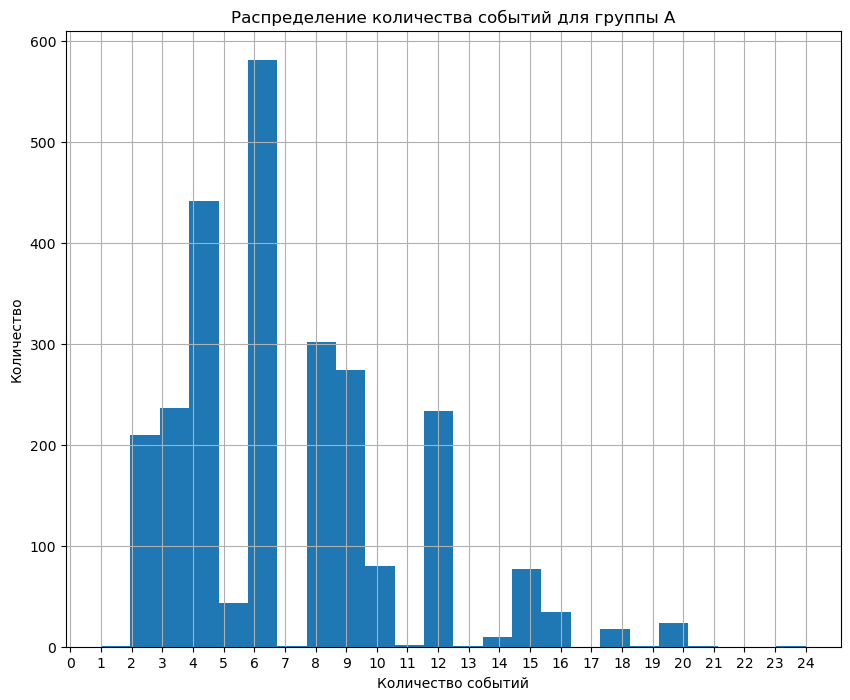

In [62]:
plt.figure(figsize = (10,8))
plt.hist(gr_a, bins = 24)
plt.grid()
plt.xticks(range(25))
plt.xlabel('Количество событий')
plt.ylabel('Количество')
plt.title('Распределение количества событий для группы А');

In [63]:
gr_b = system_test.query('group == "B"').pivot_table(index = 'user_id', values = 'event_dt', aggfunc = 'count')

In [64]:
gr_b.describe()

,event_dt
count,642.000000
mean,5.500000
std,3.239407
min,1.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,24.000000


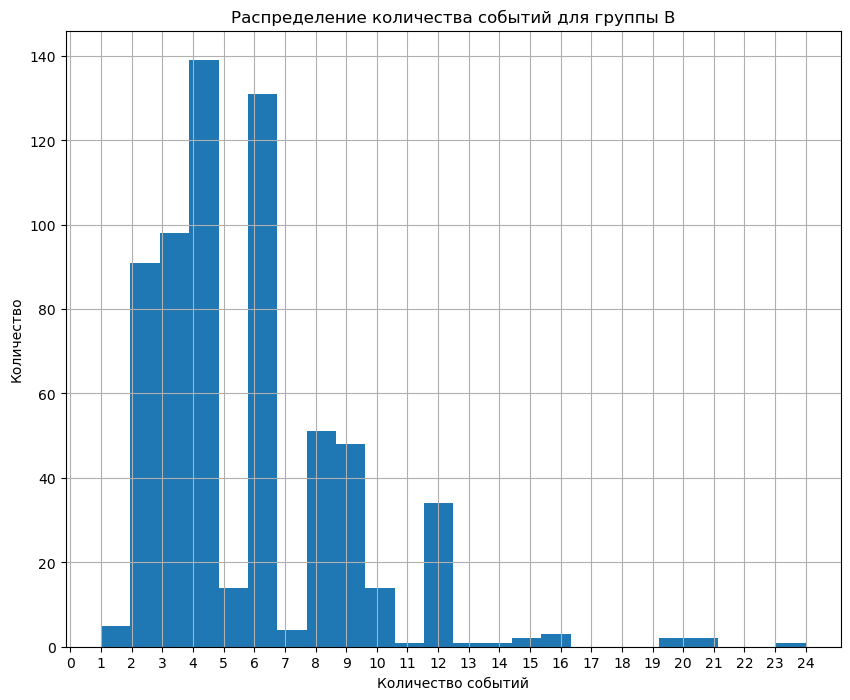

In [65]:
plt.figure(figsize = (10,8))
plt.hist(gr_b, bins = 24)
plt.grid()
plt.xticks(range(25))
plt.xlabel('Количество событий')
plt.ylabel('Количество')
plt.title('Распределение количества событий для группы B');

В среднем, у группы А больше пользователей - 6.92 против 5.50 (группа В). Медианное значение А (6) тоже больше, чем у группы В (4). Нельзя сказать почему так происходит из-за того, что очень несбалансированные группы.

Мы видим, что форма распределения очень схожа, построим эти 2 графика в одном поле, чтобы понимать масштабы.

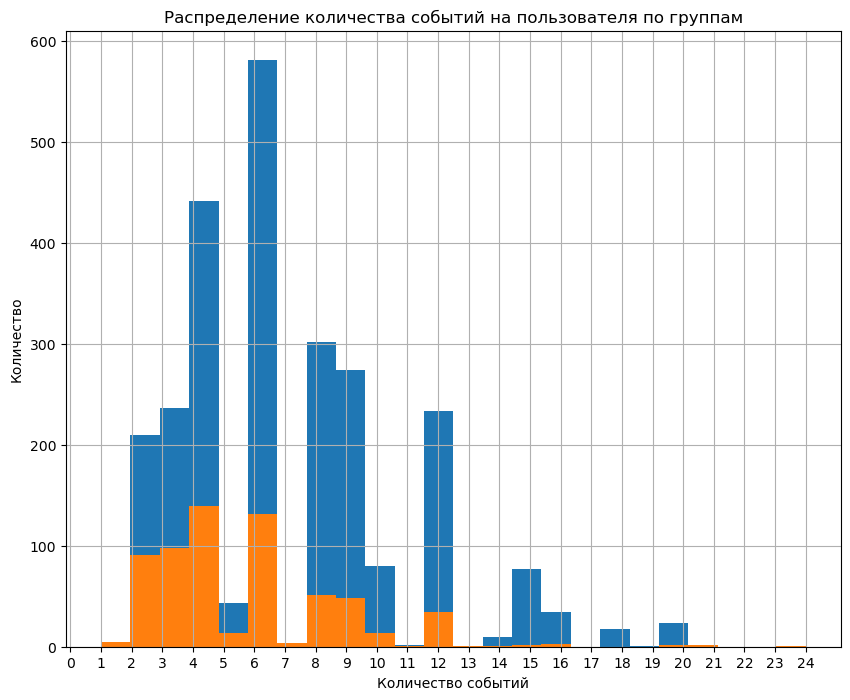

In [66]:
plt.figure(figsize = (10,8))
plt.hist(gr_a, bins = 24)
plt.hist(gr_b, bins = 24)
plt.grid()
plt.xticks(range(25))
plt.xlabel('Количество событий')
plt.ylabel('Количество')
plt.title('Распределение количества событий на пользователя по группам')
plt.show();

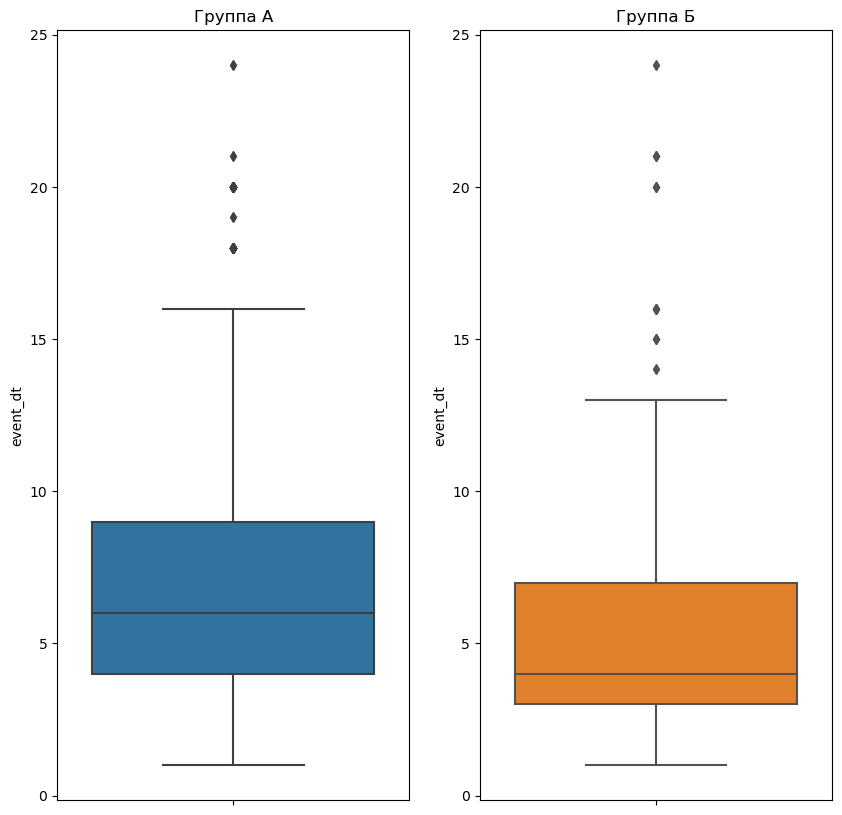

In [67]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(10,10))
fig.suptitle('')

sns.boxplot(ax=ax[0], y=gr_a['event_dt'], color='tab:blue')
ax[0].set_title('Группа А')

sns.boxplot(ax=ax[1], y=gr_b['event_dt'], color='tab:orange')
ax[1].set_title('Группа Б')

plt.show();

**Проведем статистический тест, чтобы убедиться в результатах**

Нулевая гипотеза: Количество событий на пользователя одинаково распределены в обеих выборках. <br>
Альтернативная гипотеза: Количество событий на пользователя распределены неодинаково. <br>
P-value = 0.05 <br>
Для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни, т.к мы не можем быть уверены, что данные распределены нормально

In [68]:
sample_11 = gr_a['event_dt']
sample_12 = gr_b['event_dt']

alpha = 0.05  # критический уровень статистической значимости

results = stats.mannwhitneyu(sample_11, sample_12)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  1.5526168161870762e-20
Отвергаем нулевую гипотезу: разница статистически значима


**4.2 Как число событий в выборках распределено по дням?**

In [69]:
cnt_evnt_gr_a = system_test.query('group == "A"')\
.pivot_table(index = pd.to_datetime(system_test['event_dt']).dt.date, values = 'event_name', aggfunc = 'count').reset_index()

In [70]:
cnt_evnt_gr_b = system_test.query('group == "B"')\
.pivot_table(index = pd.to_datetime(system_test['event_dt']).dt.date, values = 'event_name', aggfunc = 'count').reset_index()

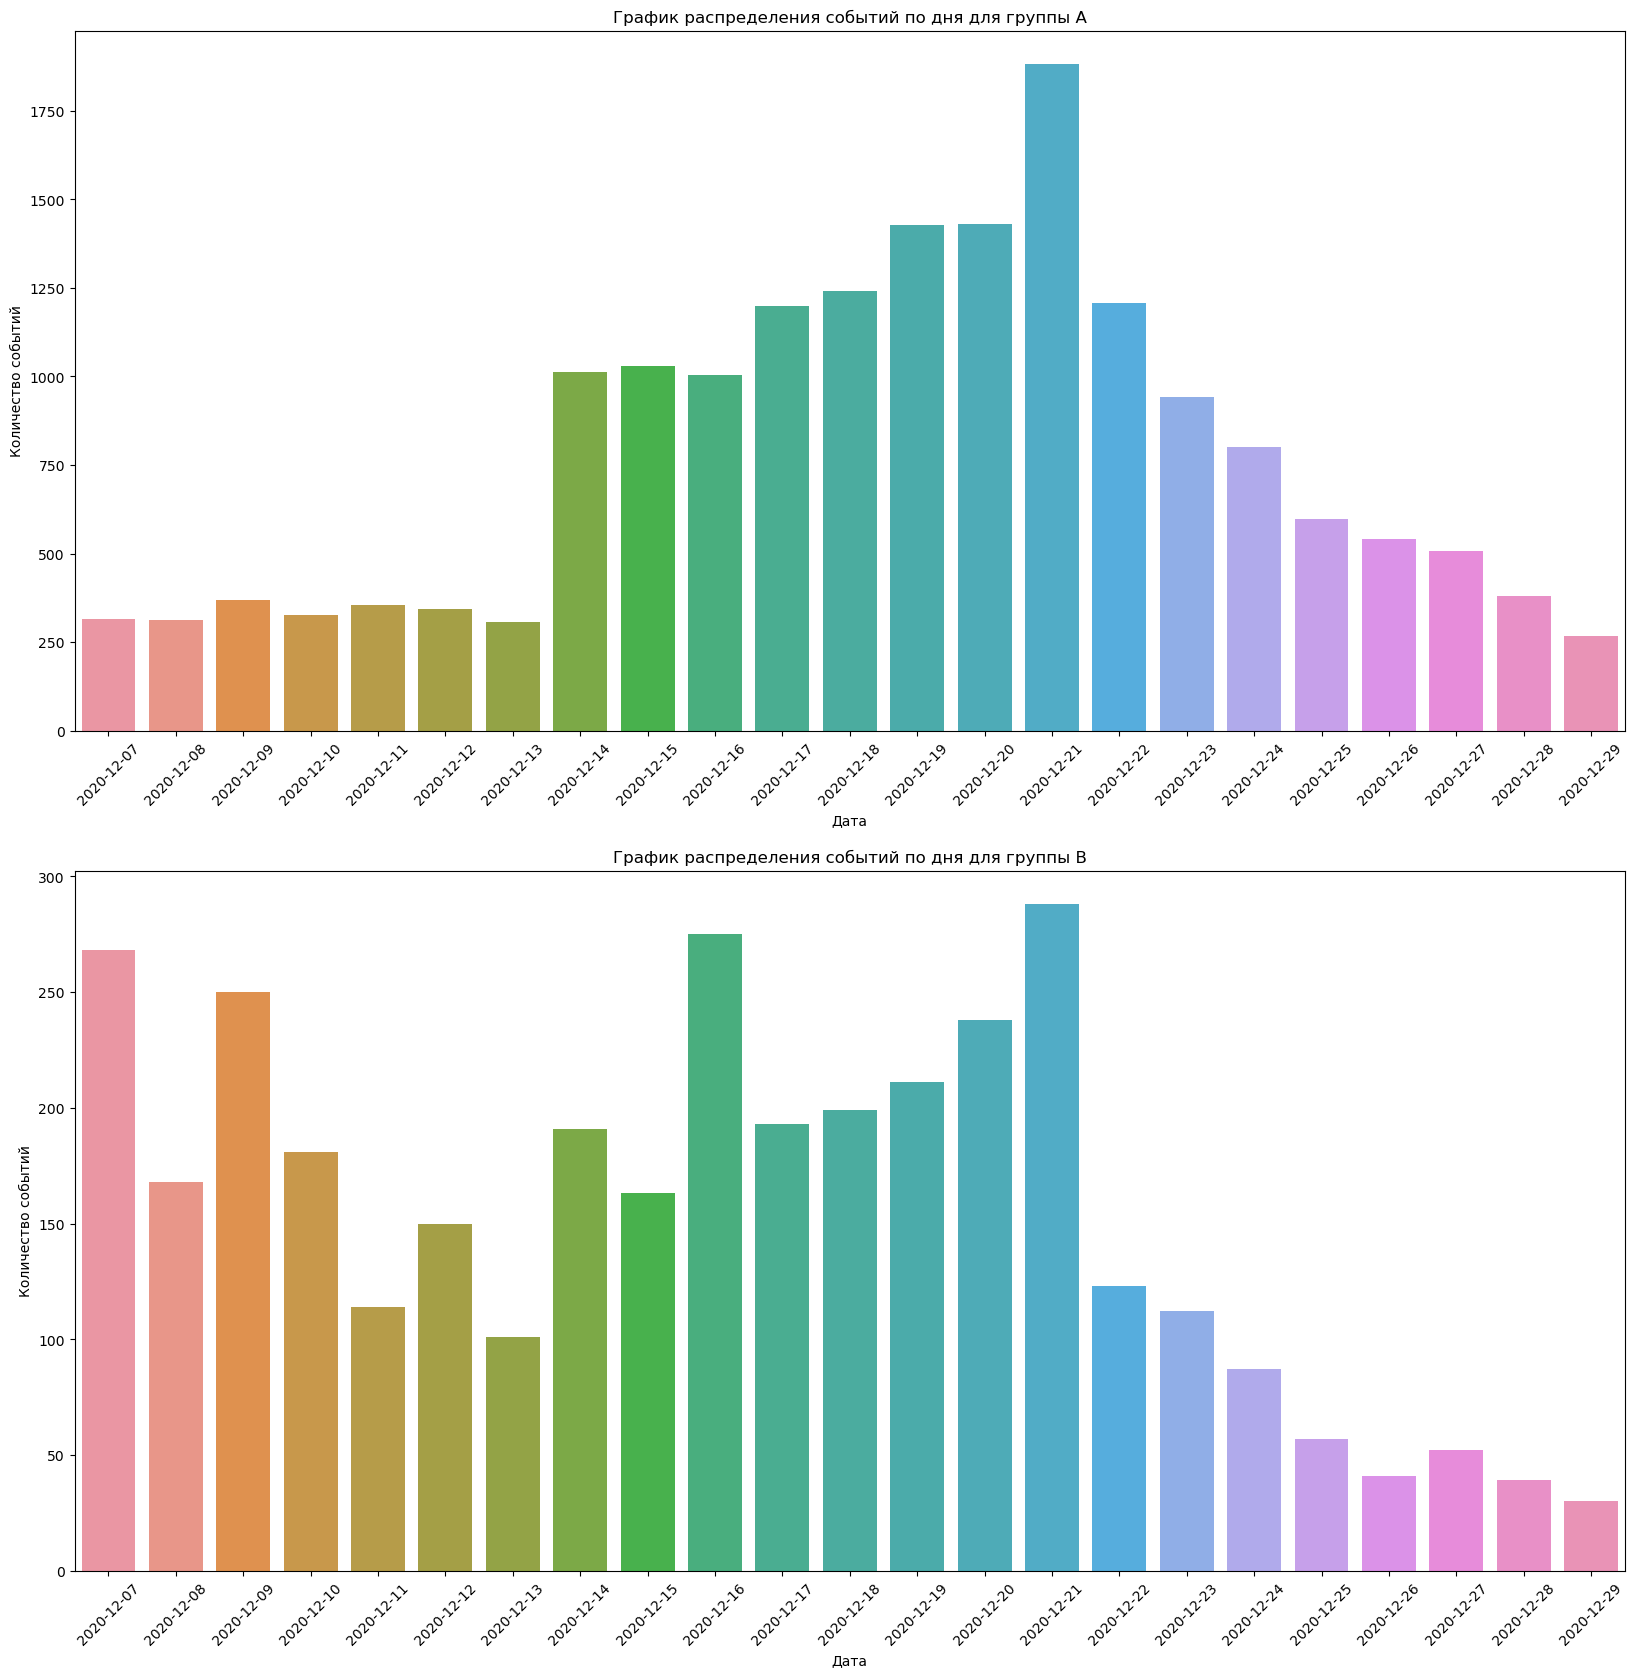

In [71]:
fig, ax = plt.subplots(2,1, figsize=(20,20))

sns.barplot(ax = ax[0], x = cnt_evnt_gr_a['event_dt'], y=cnt_evnt_gr_a['event_name'])

sns.barplot(ax = ax[1], x = cnt_evnt_gr_b['event_dt'], y=cnt_evnt_gr_b['event_name'])
labels = cnt_evnt_gr_a['event_dt']
ax[0].set_xticklabels(labels, rotation = 45)
ax[0].set_title('График распределения событий по дня для группы А')
ax[1].set_title('График распределения событий по дня для группы B')
ax[1].set_xticklabels(labels, rotation = 45)

ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Количество событий')

ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Количество событий');

Для группы А - большие всплески 14 декабря, после которого количество событий растет, и 21 декабря - максимум (возможно это как-то связано с началом недели), для B  - 7,9,17,21 декабря большие всплески.

Скачек событий в группе А с 14 числа связан со скачком новых пользователей. На графике динамики набора новых пользователей по группам мы видим скачки 14 и 21 числа для группы А.

In [72]:
plot_new_user = system_test.groupby(['first_date','group']).agg({'user_id':'nunique'}).reset_index()

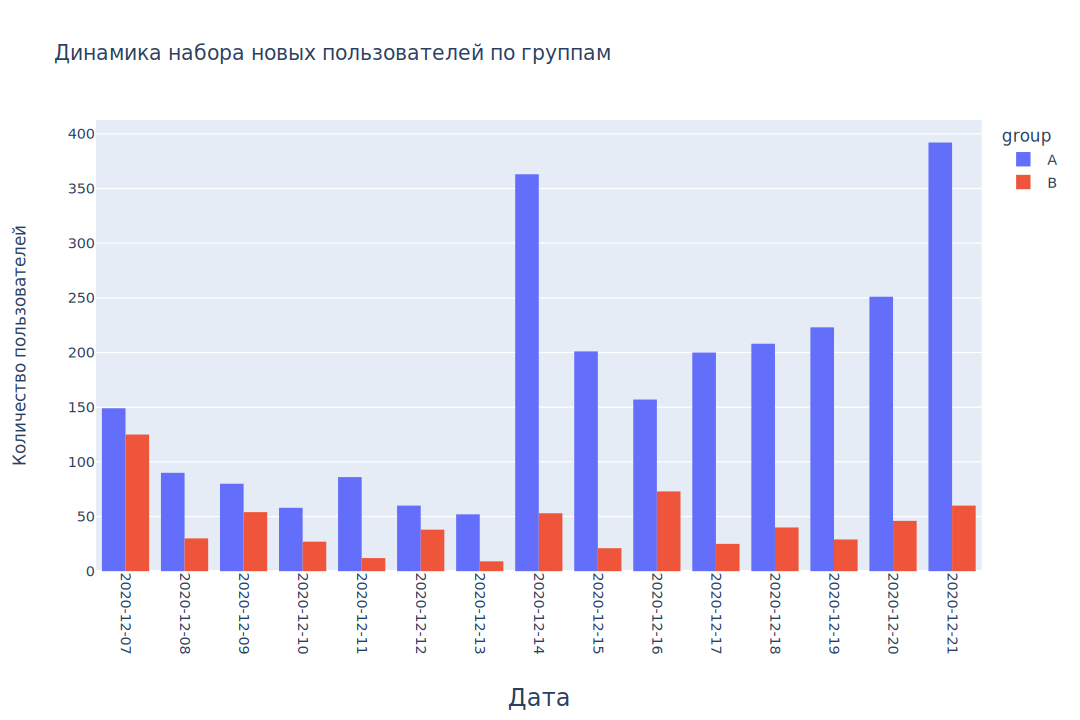

In [73]:
df = px.data.tips()
fig = px.histogram(plot_new_user, x='first_date', y='user_id',
             color='group', barmode='group',
             height=1000, title="Динамика набора новых пользователей по группам")

fig.update_layout(
    width=900,
    height=600,)

fig.update_xaxes(type='category')

fig.update_xaxes(
        tickangle = 90,
        title_text = "Дата",
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_yaxes(
        title_text = "Количество пользователей",
        title_standoff = 25)

fig.show(renderer = 'png', width = 900, height = 500 ,scale = None)


**4.3 Как меняется конверсия в воронке в выборках на разных этапах?**

In [74]:
funnel = system_test.pivot_table(index='event_name', columns='group', values='user_id',  aggfunc='nunique').reset_index()
funnel = funnel.reindex([0,2,1,3])

funnel

group,event_name,A,B
0,login,2570,641
2,product_page,1685,367
1,product_cart,782,184
3,purchase,833,191


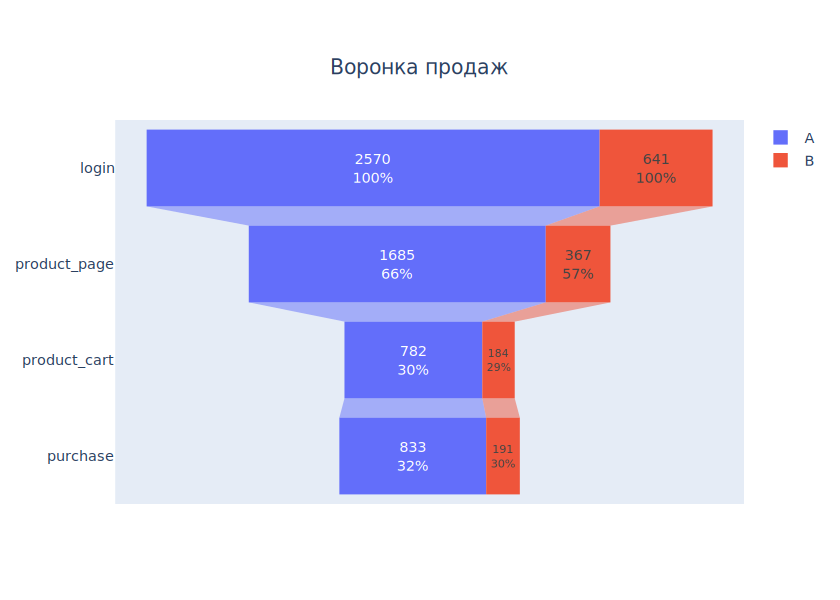

In [75]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel['event_name'],
    x = funnel['A'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel['event_name'],
    x = funnel['B'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
    title={
        'text': "Воронка продаж",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show(renderer = 'png', width = 900, height = 500,scale = None)

По воронке видно, что группа B, 'проигрывает' контрольной группе "A" на каждом шаге. Также для события product_cart количество пользователей меньше, чем в следущем шаге воронки (purchase). Из этого можно сделать вывод, что product_cart необязательный шаг.

# 5 A/B тестирование

**5.1 Результаты A/B тестирования**

* В датасет попали пользователи из другого теста (interface_eu_test). Посмотрим, есть ли люди из группы Б, которые попали в оба теста одновременно, если есть, удалим их.

* В столбце с группами корректные значения

* Минимальная дата 7 декабря 2020 года. Все как в ТЗ.

* Максимальная дата 20 декабря 2020 года. Дата остановки набора новых пользователей по тз 21 декабря 2020 года. Нет противоречий с ТЗ
* Также отсечем события, которые совершались после 01-04-2021 (по ТЗ).

* Отсечем пользователей, которые не из региона EU

* Отсечем пользователей, которые не совершали никаких действий после региcтрации

* Отсечем события пользователей, после 14 дня. Т.к в ТЗ результат должен быть спустя 14 дней после регистрации

* Пользователей, которые участвуют в обеих группах нет

* Пользователей, которых не состоят ни в одной из групп тоже нет

* Доля  новых  пользователей из EU - 15%

* Группы не сбалансированы, разница составляет почти 75% или 1928 пользователей в абсолютных показателях. 2570 - пользователей в группе А. 642 - пользователей в группе Б

* Во время проведения теста попадает только "Christmas&New Year Promo", потому что проводится в регионе EU, который нас интересует. Время проведения с 25-12-2020 по 03-01-2021.

* По результатам проверки не найдено пересечений, это значит, что все пользователи, которые попали в конкурирующий тест находятся также в группе Б

* В среднем, у группы А больше пользователей - 6.92 против 5.50 (группа В). Медианное значение А (6) тоже больше, чем у группы В (4). Нельзя сказать почему так происходит из-за того, что очень несбалансированные группы.

* По результатам статистического теста выяснилось, что Количество событий на пользователя распределены неодинаково.

* Для группы А - большие всплески 14 декабря, после которого количество событий растет, и 21 декабря - максимум (возможно это как-то связано с началом недели), для B - 7,9,17,21 декабря большие всплески.

* Скачек событий в группе А с 14 числа связан со скачком новых пользователей. На графике динамики набора новых пользователей по группам мы видим скачки 14 и 21 числа для группы А.

* По воронке видно, что группа B, 'проигрывает' контрольной группе "A" на каждом шаге. Также для события product_cart количество пользователей меньше, чем в следущем шаге воронки (purchase). Из этого можно сделать вывод, что product_cart необязательный шаг.

* Статистически значимая разница есть только для события product_page. Однако полагаться на полученный результат нельзя, т.к. тест проведен некорректно.

**5.2 z тест**

Для каждого события сформулируем нулевую и альтернативную теории. Т.к для всех событий они будут идентичны, оставим только одну формулировку

H0: Между долями нет статистически значимой разницы <br>
H1: Между долями есть статистически значимая разницы <br>
Уровень статистической значимость a = 0.05

Так как у нас множественный тест (будет 4 проверки), стоит применить поправку Бонферрони

a=0.05/4

Подготовим датасет

In [76]:
ab_ztest = system_test.groupby('group').agg({'user_id':'nunique'})

In [77]:
ab_ztest['share'] = (ab_ztest['user_id']/ system_test['user_id'].nunique())*100

In [78]:
ab_ztest

,user_id,share
group,,
A,2570,80.012453
B,642,19.987547


In [79]:
def z_test(group1, group2, alpha):

    for i in funnel.index:

        p1 = funnel[group1][i] / ab_ztest['user_id'][0]

        p2 = funnel[group2][i] / ab_ztest['user_id'][1]

        print(funnel[group1][i], funnel[group2][i], ab_ztest['user_id'][0], ab_ztest['user_id'][1])

        p_comb = (funnel[group1][i] + funnel[group2][i]) / (ab_ztest['user_id'][0] + ab_ztest['user_id'][1])

        diff = p1 - p2

        z_value = diff/mth.sqrt(p_comb*(1-p_comb)*(1/ab_ztest['user_id'][0]+ 1/ab_ztest['user_id'][1]))

        distr = stats.norm(0,1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('Для события', funnel['event_name'][i], '- p-value:', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу - между долями есть статистически значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу - между долями нет статистически значимой разницы')
        print()


In [80]:
z_test('A','B', 0.05/4)

2570 641 2570 642
Для события login - p-value: 0.04538267122479556
Не получилось отвергнуть нулевую гипотезу - между долями нет статистически значимой разницы

1685 367 2570 642
Для события product_page - p-value: 7.397840037981496e-05
Отвергаем нулевую гипотезу - между долями есть статистически значимая разница

782 184 2570 642
Для события product_cart - p-value: 0.38234191482711033
Не получилось отвергнуть нулевую гипотезу - между долями нет статистически значимой разницы

833 191 2570 642
Для события purchase - p-value: 0.19549196973230054
Не получилось отвергнуть нулевую гипотезу - между долями нет статистически значимой разницы



Статистически значимая разница есть только для события product_page. Однако полагаться на полученный результат нельзя, т.к. тест проведен некорректно.

# 6 Вывод

* В датасет попали пользователи из другого теста (interface_eu_test). Посмотрим, есть ли люди из группы Б, которые попали в оба теста одновременно, если есть, удалим их.

* В столбце с группами корректные значения

* Минимальная дата 7 декабря 2020 года. Все как в ТЗ.

* Максимальная дата 20 декабря 2020 года. Дата остановки набора новых пользователей по тз 21 декабря 2020 года. Нет противоречий с ТЗ
* Также отсечем события, которые совершались после 01-04-2021 (по ТЗ).

* Отсечем пользователей, которые не из региона EU

* Отсечем пользователей, которые не совершали никаких действий после региcтрации

* Отсечем события пользователей, после 14 дня. Т.к в ТЗ результат должен быть спустя 14 дней после регистрации

* Пользователей, которые участвуют в обеих группах нет

* Пользователей, которых не состоят ни в одной из групп тоже нет

* Доля  новых  пользователей из EU - 15%

* Группы не сбалансированы, разница составляет почти 75% или 1928 пользователей в абсолютных показателях. 2570 - пользователей в группе А. 642 - пользователей в группе Б

* Во время проведения теста попадает только "Christmas&New Year Promo", потому что проводится в регионе EU, который нас интересует. Время проведения с 25-12-2020 по 03-01-2021.

* По результатам проверки не найдено пересечений, это значит, что все пользователи, которые попали в конкурирующий тест находятся также в группе Б

Если рассматривать это как готовый и "очищенный" АБ тест, то качество данных не позволяет делать обоснованных выводов.
1. С временными отезками все неплохо
2. Набор групп выполнен некорректно, т.к в тест попали пользоватили из конкурирующего теста (при чем попали в группу Б).
3. 15% новых пользоватей - соблюдено
4. Ожидаемое количество участников 6000, по факту - 3212
5. Ожидаемый эффект: за 14 дней улучшение каждой метрики не менее, чем на 10%. Это мы проверим в следующих пунутах

* В среднем, у группы А больше пользователей - 6.92 против 5.50 (группа В). Медианное значение А (6) тоже больше, чем у группы В (4). Нельзя сказать почему так происходит из-за того, что очень несбалансированные группы.

* По результатам статистического теста выяснилось, что Количество событий на пользователя распределены неодинаково.

* Для группы А - большие всплески 14 декабря, после которого количество событий растет, и 21 декабря - максимум (возможно это как-то связано с началом недели), для B - 7,9,17,21 декабря большие всплески.

* Скачек событий в группе А с 14 числа связан со скачком новых пользователей. На графике динамики набора новых пользователей по группам мы видим скачки 14 и 21 числа для группы А.

* По воронке видно, что группа B, 'проигрывает' контрольной группе "A" на каждом шаге. Также для события product_cart количество пользователей меньше, чем в следущем шаге воронки (purchase). Из этого можно сделать вывод, что product_cart необязательный шаг.

* Статистически значимая разница есть только для события product_page. Однако полагаться на полученный результат нельзя, т.к. тест проведен некорректно.

* Рекомендуется провести тест заново, сбалансировав группы по количеству.
